<a href="https://colab.research.google.com/github/YardenGoraly/Mujoco_fun/blob/main/MuJoCo_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

test_plt

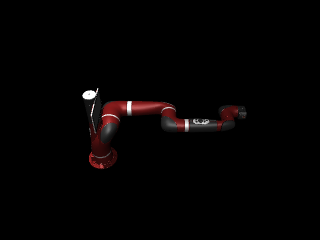

initial pos => [0.991  0.1603 0.317 ]
initial quat => [0.06162741 0.70441871 0.06162741 0.70441351]


test_plt

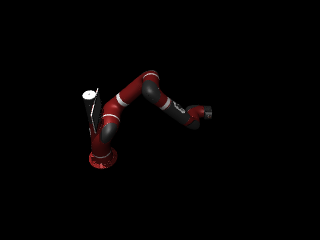

Target pos => [0.75668542 0.1603     0.317     ]
target quat => [0.06162741 0.70441871 0.06162741 0.70441351]


In [25]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media
from utils import *

# xml = "mujoco_menagerie/universal_robots_ur5e/scene.xml"
xml = "mujoco_menagerie/rethink_robotics_sawyer/sawyer.xml"
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

ee = "right_l6"

# initial joint angle
data.qpos = [0, 0, 0, 0, 0, 0, 0]

# test plot
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
test_plt = renderer.render()
images = {'test_plt': test_plt,}
media.show_images(images)

initial_pos = data.body(ee).xpos
initial_quart = data.body(ee).xquat
print("initial pos =>",initial_pos)
print("initial quat =>",initial_quart)


# target joint angle
pi = np.pi
# data.qpos = [3*pi/2, -pi/2, pi/2, 3*pi/2, 3*pi/2, 0,0]
data.qpos = [0, -pi/4, 0, pi/2, 0, -pi/4, 0]

# qpos0 = data.qpos.copy()
# test plot
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
test_plt = renderer.render()
images = {'test_plt': test_plt,}
media.show_images(images)

target_pos = data.body(ee).xpos
print("Target pos =>",target_pos)
target_quart = data.body(ee).xquat
print("target quat =>",target_quart)

In [ ]:
# Levenberg-Marquardt method
class LevenbergMarquardtIK:
    
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr, damping):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
        self.damping = damping
    
    def check_joint_limits(self, q):
        """Check if the joints are under or above their limits"""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], 
                       min(q[i], self.model.jnt_range[i][1]))

    # Levenberg-Marquardt pseudocode implementation
    def calculate(self, goal_position, goal_quaternion, init_q, body_id):
        """Calculate the desired joint angles for goal (position and orientation)"""
        print ("start calculate inverse kinematics")
        
        # make sure the model is in initial state
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        
        # extract pose (position and orientation)
        current_position = self.data.body(body_id).xpos
        current_quaternion = self.data.body(body_id).xquat
        
        # calculate current error
        position_error = np.subtract(goal_position, current_position)
        orientation_error = quaternion_error_naive(current_quaternion, goal_quaternion) # Compute orientation error (quaternion error)
        error = np.concatenate((position_error, orientation_error)) # Combine position and orientation errors

        print("start while loop")

        while np.linalg.norm(error) >= self.tol:
            # calculate jacobian (both position and orientation)
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, current_position, body_id)
            jac = np.vstack([self.jacp, self.jacr[:3,:]])
            
            # Levenberg Marquardt update
            I = np.identity(jac.shape[1])
            product = jac.T @ jac + self.damping * I
            
            if np.isclose(np.linalg.det(product), 0):
                j_inv = np.linalg.pinv(product) @ jac.T
            else:
                j_inv = np.linalg.inv(product) @ jac.T

            delta_q = j_inv @ error

            # update joint positions
            self.data.qpos += self.step_size * delta_q  # compute next step
            self.check_joint_limits(self.data.qpos)  # check limits
            mujoco.mj_forward(self.model, self.data)  # compute forward kinematics

            # Recompute errors
            current_position = self.data.body(body_id).xpos
            current_quaternion = self.data.body(body_id).xquat
            position_error = np.subtract(goal_position, current_position)
            orientation_error = self.quaternion_error_naive(current_quaternion, goal_quaternion)
            error = np.concatenate((position_error, orientation_error))  # combine errors

        return self.data.qpos  # return the final joint positions




7
start calculate inverse kinematics
Current Position => [0.991  0.1603 0.317 ]
Goal Position => [0.75668542 0.1603     0.317     ]
Position Error => [-0.23431458  0.          0.        ]
Orientation Error => [-5.30292074e-10 -5.71986902e-13  5.20000709e-14]
start while loop
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)
error shape (6,)
jac shape (6, 7)
j_inv shape (7, 6)

Testing point,Levenberg-Marquardt result

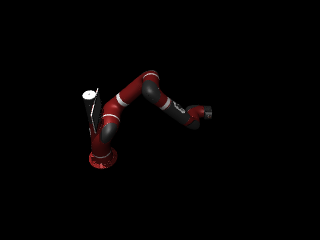
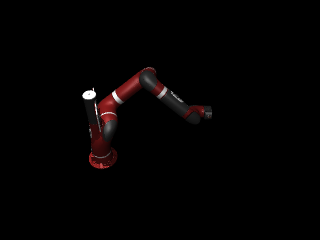

In [43]:

#Init variables.
body_id = model.body(ee).id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
# goal = np.array([0.75668542, 0.1603,     0.317     ])
target_pos = np.array([0.75668542, 0.1603,     0.317     ])
target_quat = np.array([0.06162741, 0.70441871, 0.06162741, 0.70441351])

# print ("Goal =>",goal)

print (model.nv)

step_size = 0.5
tol = 0.00001
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
damping = 0.15

mujoco.mj_forward(model, data)

ik = LevenbergMarquardtIK(model, data, step_size, tol, alpha, jacp, jacr, damping)

#Get desire point
# mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(target_pos, target_quat, init_q, body_id) #calculate the qpos

result = data.qpos.copy()

#Plot results
print("Results")
data.qpos = [0, -pi/4, 0, pi/2, 0, -pi/4, 0]
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
result_plot = renderer.render()
result_pos = data.body(ee).xpos
result_quat = data.body(ee).xquat


print("target pos =>", target_pos)
print("Levenberg-Marquardt pos =>", result_pos, "\n")

print("target quat =>", target_quart)
print("Levenberg-Marquardt quat =>", result_quat, "\n")



images = {
    'Testing point': target_plot,
    'Levenberg-Marquardt result': result_plot,
}

media.show_images(images)